In [ ]:
# CONNECT TO GOOGLE DRIVE

# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# DEFINE BASE URL (CURRENT PROJECT)

# For colab
# base_url = '/content/drive/MyDrive/AI_Denoising_Experiment' 

# For local on VS code
base_url = '../../adi-denoising-be'

In [2]:
# DEFINE DEVICE FOR HANDLE
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Program Files\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm

# 1. FEATURE EXTRACTION (STFT)

# Config 
sample_rate = 16000
n_fft = 512
hop_length = 128
win_length = 512
window_fn = torch.hann_window

# Path
clean_dir = os.path.join(base_url, 'data/clean')
noisy_dir = os.path.join(base_url, 'data/noisy')

save_clean_mag_dir = os.path.join(base_url, 'data/features/clean_stft_mag')
save_noisy_dir = os.path.join(base_url, 'data/features/noisy_stft_mag_phase')

os.makedirs(save_clean_mag_dir, exist_ok=True)
os.makedirs(save_noisy_dir, exist_ok=True)

# Function to calcualte STFT
def compute_stft(wav):
    window = window_fn(win_length)
    stft = torch.stft(wav, n_fft=n_fft, hop_length=hop_length,
                      win_length=win_length, window=window,
                      return_complex=True)
    mag = torch.abs(stft)
    phase = torch.angle(stft)
    return mag, phase

# Handle for clean (only save mag)
print(">>> Processing CLEAN files")
for file_name in tqdm(os.listdir(clean_dir)):
    if not file_name.endswith('.wav'):
        continue
    path = os.path.join(clean_dir, file_name)
    wav, sr = torchaudio.load(path)
    wav = wav.mean(dim=0)  # mix stereo to mono if needed
    if sr != sample_rate:
        wav = torchaudio.functional.resample(wav, sr, sample_rate)
    mag, _ = compute_stft(wav)
    torch.save(mag, os.path.join(save_clean_mag_dir, file_name.replace('.wav', '.pt')))

# Handle noisy (save mag and phase)
print(">>> Processing NOISY files")
for file_name in tqdm(os.listdir(noisy_dir)):
    if not file_name.endswith('.wav'):
        continue
    path = os.path.join(noisy_dir, file_name)
    wav, sr = torchaudio.load(path)
    wav = wav.mean(dim=0)
    if sr != sample_rate:
        wav = torchaudio.functional.resample(wav, sr, sample_rate)
    mag, phase = compute_stft(wav)

    # Save to dict {'mag': ..., 'phase': ...}
    torch.save({'mag': mag, 'phase': phase},
               os.path.join(save_noisy_dir, file_name.replace('.wav', '.pt')))

In [ ]:
import os
import random
import csv

# 2. SPLIT DATASET: TRAIN, VAL AND TEST

# Path
noisy_feature_dir = os.path.join(base_url, 'data/features/noisy_stft_mag_phase')
clean_feature_dir = os.path.join(base_url, 'data/features/clean_stft_mag')
output_csv_dir = os.path.join(base_url, 'data/splits')
os.makedirs(output_csv_dir, exist_ok=True)

# Percent for each dataset
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Brow noisy files
noisy_files = [f for f in os.listdir(noisy_feature_dir) if f.endswith('.pt')]
matched_pairs = []

for noisy_file in noisy_files:
    # Extract clean name từ noisy name
    # Example: noisy_clean_001__noise_003__snr5.pt -> clean_001.pt
    try:
        clean_part = noisy_file.split('__')[0].replace('noisy_', '') + '.pt'
        clean_path = os.path.join(clean_feature_dir, clean_part)
        if os.path.exists(clean_path):
            matched_pairs.append((noisy_file, clean_part))
    except Exception as e:
        print(f"Lỗi xử lý file: {noisy_file} -> {e}")

# Shuffle and divide
random.shuffle(matched_pairs)
total = len(matched_pairs)
n_train = int(total * train_ratio)
n_val = int(total * val_ratio)

train_set = matched_pairs[:n_train]
val_set = matched_pairs[n_train:n_train + n_val]
test_set = matched_pairs[n_train + n_val:]

# Function to save cs file
def save_csv(pairs, filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['noisy', 'clean'])
        writer.writerows(pairs)

save_csv(train_set, os.path.join(output_csv_dir, 'train.csv'))
save_csv(val_set, os.path.join(output_csv_dir, 'val.csv'))
save_csv(test_set, os.path.join(output_csv_dir, 'test.csv'))

print(f"Savved at train/val/test csv ({len(train_set)}/{len(val_set)}/{len(test_set)} files)")

Đã lưu xong train/val/test csv (3478/434/436 files)


In [ ]:
import os
import csv
import torch
from tqdm import tqdm

# 3. SRANDARDIZATION: CALCUALTE MEAN AND STD
train_csv = os.path.join(base_url, "data/splits/train.csv")
noisy_feature_dir = os.path.join(base_url, "data/features/noisy_stft_mag_phase")
save_stats_path = os.path.join(base_url, "data/features/train_mag_stats.pt")

sum_mag = 0.0
sum_mag_sq = 0.0
num_elements = 0


with open(train_csv, "r") as f:
    reader = csv.DictReader(f)
    for row in tqdm(reader, desc="Calculate mean/std"):
        noisy_file = row["noisy"]
        path = os.path.join(noisy_feature_dir, noisy_file)

        data = torch.load(path)
        mag = data["mag"]  # shape: [freq, time]

        sum_mag += mag.sum().item()
        sum_mag_sq += (mag**2).sum().item()
        num_elements += mag.numel()

mean = sum_mag / num_elements
std = (sum_mag_sq / num_elements - mean**2) ** 0.5

# Save to file
torch.save({"mean": mean, "std": std}, save_stats_path)

print(f"Calculated: mean = {mean:.5f}, std = {std:.5f}")
print(f"Saved at: {save_stats_path}")

Calculate mean/std: 3478it [04:17, 13.51it/s]

Tính xong: mean = 0.44535, std = 1.74248
Lưu vào: ../data/features/train_mag_stats.pt


In [3]:
import os
import torch
import csv
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 4. DEFINE DATASET AND TEST DATALOADER

# Config
# train_csv = os.path.join(base_url, "data/splits/train.csv")
# noisy_feature_dir = os.path.join(base_url, "data/features/noisy_stft_mag_phase")
# clean_feature_dir = os.path.join(base_url, "data/features/clean_stft_mag")
stats_path = os.path.join(base_url, "data/features/train_mag_stats.pt")

# Load mean and std
stats = torch.load(stats_path)
mean = stats["mean"]
std = stats["std"]


# Dataset class
class SpeechEnhancementDataset(Dataset):
    def __init__(self, csv_file, noisy_dir, clean_dir, mean, std):
        self.csv_file = csv_file
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.mean = mean
        self.std = std

        # Load danh sách các cặp noisy-clean từ csv
        self.data = []
        with open(csv_file, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                noisy_file = row["noisy"]
                clean_file = row["clean"]
                self.data.append((noisy_file, clean_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        noisy_file, clean_file = self.data[idx]

        # Load noisy và clean
        noisy_path = os.path.join(self.noisy_dir, noisy_file)
        clean_path = os.path.join(self.clean_dir, clean_file)
        # print(noisy_path + " | " + clean_path)

        noisy_data = torch.load(noisy_path)
        clean_data = torch.load(clean_path)

        noisy_mag = noisy_data["mag"]
        clean_mag = clean_data

        # Normalize magnitude
        noisy_mag = (noisy_mag - self.mean) / self.std
        clean_mag = (clean_mag - self.mean) / self.std

        return noisy_mag.unsqueeze(0), clean_mag.unsqueeze(0)


# # Creaate Dataset and Dataloader
# train_dataset = SpeechEnhancementDataset(train_csv, noisy_feature_dir, clean_feature_dir, mean, std)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# # # Check the first batch
# for noisy_mag, clean_mag in tqdm(train_dataloader, desc="Loading batch"):
#     print(noisy_mag.shape, clean_mag.shape)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 5. DEFINE UNET MODEL


class UNetEnhanced(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256, 512]):
        super(UNetEnhanced, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1] * 2)

        # Upsampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(self.double_conv(feature * 2, feature))

        # Output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]

            # Pad if shape it does not match
            if x.shape != skip.shape:
                x = F.pad(
                    x, [0, skip.shape[3] - x.shape[3], 0, skip.shape[2] - x.shape[2]]
                )

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# 6. TRAIN MODEL

def train_model(model, train_loader, val_loader, num_epochs, device, save_path="best_model.pth"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        print(f"\n🔁 Epoch [{epoch+1}/{num_epochs}]")
        train_bar = tqdm(train_loader, desc="🚂 Training", leave=False)
        for noisy, clean in train_bar:
            noisy, clean = noisy.to(device), clean.to(device)

            outputs = model(noisy)
            loss = criterion(outputs, clean)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        val_bar = tqdm(val_loader, desc="🧪 Validating", leave=False)
        with torch.no_grad():
            for noisy, clean in val_bar:
                noisy, clean = noisy.to(device), clean.to(device)
                outputs = model(noisy)
                loss = criterion(outputs, clean)
                running_val_loss += loss.item()
                val_bar.set_postfix(val_loss=loss.item())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"📊 Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model at epoch {epoch+1} with val_loss {val_loss:.4f}")

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curve.png")
    print("📈 Loss curve saved as loss_curve.png")

    return model

In [ ]:
# EXCUTE TRAIN MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetEnhanced()

# Path
train_csv = os.path.join(base_url, "data/splits/train.csv")
val_csv = os.path.join(base_url, "data/splits/val.csv")
noisy_feature_dir = os.path.join(base_url, "data/features/noisy_stft_mag_phase")
clean_feature_dir = os.path.join(base_url, "data/features/clean_stft_mag")
stats_path = os.path.join(base_url, "data/features/train_mag_stats.pt")
save_path = os.path.join(base_url, "data/model/unet_speech_denoising_best.pth")

# Create Dataset and Dataloader
train_dataset = SpeechEnhancementDataset(
    train_csv, noisy_feature_dir, clean_feature_dir, mean, std
)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = SpeechEnhancementDataset(
    val_csv, noisy_feature_dir, clean_feature_dir, mean, std
)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

trained_model = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=50,
    device=device,
    save_path=save_path,
)

🧪 Evaluating: 100%|██████████| 28/28 [12:41<00:00, 27.20s/it]


📉 Average Test Loss (MSE): 0.013025
📈 Saved test loss curve as test_loss_curve.png


0.013024824471878154

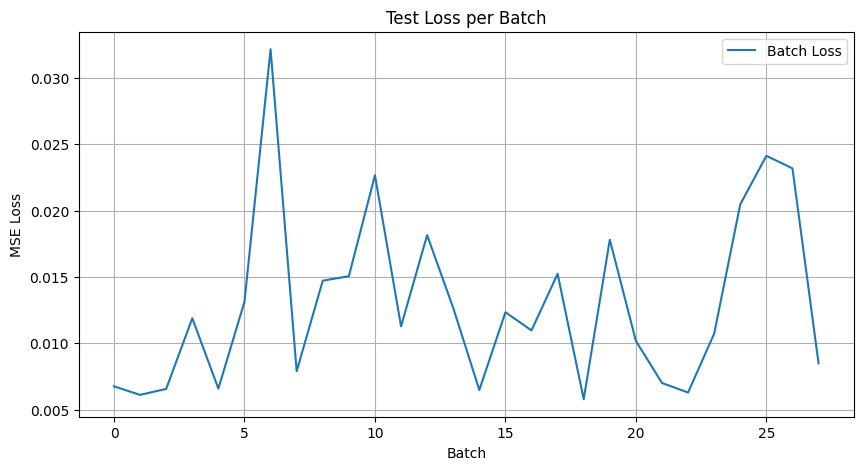

In [13]:
from torch.utils.data import DataLoader

# 7. EVALUATE

# Path
test_csv = os.path.join(base_url, 'data/splits/test.csv')
model_path = os.path.join(base_url, "data/model/unet_speech_denoising_best.pth")
noisy_feature_dir = os.path.join(base_url, 'data/features/noisy_stft_mag_phase')
clean_feature_dir = os.path.join(base_url, 'data/features/clean_stft_mag')

# Load mean and std
stats_path = '../data/features/train_mag_stats.pt'
stats = torch.load(stats_path)
mean = stats['mean']
std = stats['std']

# Create test loader
test_dataset = SpeechEnhancementDataset(test_csv, noisy_feature_dir, clean_feature_dir, mean, std)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load model
model = UNetEnhanced()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)

# Function to evaluate
def evaluate_model(model, test_loader, device, plot_loss=True):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    batch_losses = []

    with torch.no_grad():
        for noisy, clean in tqdm(test_loader, desc="🧪 Evaluating"):
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            batch_losses.append(loss.item())
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"📉 Average Test Loss (MSE): {avg_loss:.6f}")

    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(batch_losses, label="Batch Loss")
        plt.xlabel("Batch")
        plt.ylabel("MSE Loss")
        plt.title("Test Loss per Batch")
        plt.grid(True)
        plt.legend()
        plt.savefig("test_loss_curve.png")
        print("📈 Saved test loss curve as test_loss_curve.png")

    return avg_loss

# Call function
evaluate_model(model, test_loader, device, plot_loss=True)

In [5]:
import torchaudio
import torch
import os

# 8. DENOISE ANY NOISY FILE

def denoise_wav_file(model, noisy_wav_path, mean, std, save_path, device):
    model.eval()

    # Load file wav
    wav, sr = torchaudio.load(noisy_wav_path)
    wav = wav.mean(dim=0)  # If stereo, mix to mono
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)

    # Calcualte STFT
    window = torch.hann_window(512).to(wav.device)
    stft = torch.stft(wav, n_fft=512, hop_length=128, win_length=512,
                      window=window, return_complex=True)  # (F, T)
    noisy_mag = torch.abs(stft)
    noisy_phase = torch.angle(stft)

    # Extraction magnitude
    noisy_mag_norm = (noisy_mag - mean) / std
    input_tensor = noisy_mag_norm.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, F, T)

    with torch.no_grad():
        denoised_mag_norm = model(input_tensor)

    # Denormalization
    denoised_mag = denoised_mag_norm.squeeze().cpu() * std + mean  # (F, T)

    # Create complex spec
    real = denoised_mag * torch.cos(noisy_phase)
    imag = denoised_mag * torch.sin(noisy_phase)
    complex_spec = torch.complex(real, imag)

    # ISTFT
    denoised_waveform = torch.istft(
        complex_spec,
        n_fft=512,
        hop_length=128,
        win_length=512,
        window=torch.hann_window(512),
        length=wav.shape[0]  # để đảm bảo khôi phục đúng chiều dài
    )

    # Write to wav file
    torchaudio.save(save_path, denoised_waveform.unsqueeze(0), sample_rate=16000)
    print(f"✅ File denoised đã lưu tại: {save_path}")

In [6]:
# EXCUTE DENOSY FILE

# Load model
model_path = "./model/unet_speech_denoising_best.pth"
stats_path = '../data/features/train_mag_stats.pt'

stats = torch.load(stats_path)
mean = stats['mean']
std = stats['std']


model = UNetEnhanced()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)

# Denoise file WAV
noisy_wav_path = "./tmp/mixed_snr5_5s.wav"
output_path = "./tmp/result.wav"
denoise_wav_file(model, noisy_wav_path, mean, std, output_path, device)

✅ File denoised đã lưu tại: ./tmp/result.wav


In [ ]:
import torchaudio
import torch
import os
import tempfile
from tqdm import tqdm

def denoise_long_wav_file(model, noisy_path, mean, std, output_path, device='cpu', segment_sec=5):
    model.eval()

    # Load file, chuyển về 16kHz và mono nếu cần
    wav, sr = torchaudio.load(noisy_path)
    wav = wav.mean(dim=0)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
        sr = 16000

    segment_len = segment_sec * sr
    total_len = wav.shape[0]
    denoised_segments = []
    
    # Tính số đoạn cần xử lý
    num_segments = (total_len + segment_len - 1) // segment_len

    # Vòng lặp xử lý từng đoạn với thanh tiến trình tqdm
    for start in tqdm(range(0, total_len, segment_len), desc="Processing segments", total=num_segments):
        end = min(start + segment_len, total_len)
        chunk = wav[start:end]

        # Nếu đoạn cuối có độ dài nhỏ hơn, thêm zero-padding để đủ 5s
        if chunk.shape[0] < segment_len:
            pad_len = segment_len - chunk.shape[0]
            chunk = torch.cat([chunk, torch.zeros(pad_len)])

        # Lưu đoạn tạm ra file (sử dụng tempfile để tránh xung đột tên file)
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_in:
            torchaudio.save(tmp_in.name, chunk.unsqueeze(0), sample_rate=sr)
            tmp_in_path = tmp_in.name

        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_out:
            tmp_out_path = tmp_out.name

        # Xử lý denoise từng đoạn
        denoise_wav_file(model, tmp_in_path, mean, std, tmp_out_path, device)

        # Load lại đoạn denoise
        denoised_chunk, _ = torchaudio.load(tmp_out_path)
        denoised_segments.append(denoised_chunk.squeeze(0))

        # Xoá file tạm
        os.remove(tmp_in_path)
        os.remove(tmp_out_path)

    # Ghép tất cả các đoạn lại thành 1 file
    full_denoised = torch.cat(denoised_segments)[:total_len]  # Cắt bớt nếu có zero-padding dư
    torchaudio.save(output_path, full_denoised.unsqueeze(0), sample_rate=sr)
    print(f"🎉 File denoised toàn bộ đã lưu tại: {output_path}")

In [7]:
# Load model
model_path = "./model/unet_speech_denoising_best.pth"
stats_path = '../data/features/train_mag_stats.pt'

stats = torch.load(stats_path)
mean = stats['mean']
std = stats['std']


model = UNetEnhanced()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)

denoise_long_wav_file(
    model=model,
    noisy_path="./tmp/mixed_snr5.wav",
    mean=mean,
    std=std,
    output_path="./tmp/result.wav",
    device=device,
    segment_sec=5  # mỗi đoạn 5 giây
)

Processing segments:  20%|██        | 1/5 [00:01<00:06,  1.56s/it]

✅ File denoised đã lưu tại: C:\Users\Liliana\AppData\Local\Temp\tmpq1yinezy.wav


Processing segments:  40%|████      | 2/5 [00:03<00:04,  1.49s/it]

✅ File denoised đã lưu tại: C:\Users\Liliana\AppData\Local\Temp\tmpzwwutsfl.wav


Processing segments:  60%|██████    | 3/5 [00:04<00:03,  1.52s/it]

✅ File denoised đã lưu tại: C:\Users\Liliana\AppData\Local\Temp\tmpyvh20rsc.wav


Processing segments:  80%|████████  | 4/5 [00:06<00:01,  1.50s/it]

✅ File denoised đã lưu tại: C:\Users\Liliana\AppData\Local\Temp\tmp1fa4w_uz.wav


Processing segments: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

✅ File denoised đã lưu tại: C:\Users\Liliana\AppData\Local\Temp\tmpo6omqtez.wav


🎉 File denoised toàn bộ đã lưu tại: ./tmp/result.wav
